# COLLECTIVE CLUSTERING

In [1]:
import numpy as np
import datetime
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt

### Detalles

### Lista de Clientes

In [2]:
# Extraemos la lista de clientes sin repetir

def leer_data():
    outfile='./data/consulta.csv'
    data = pd.read_csv(outfile)
    return data

data = leer_data()
clientes =  data.groupby('client_id').client_id.count().index

## Temporal TXs footprint

In [3]:
# Definimos la ruta de los archivos 

file='U'
raw_data='./data/%s.json' %(file)

individual_footprint="%s.individual_footprint" %(raw_data)

individual_clusters="%s.clusters" %(individual_footprint)
individual_labels="%s.labels" %(individual_footprint)

collective_clusters="%s.collective_footprint.clusters" %(raw_data)
collective_labels="%s.collective_footprint.labels" %(raw_data)

### Funciones

In [4]:
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}
    for k in tests:
        if k<=len(data):
            if log:
                print("%s: processing %s"%(datetime.datetime.now(),k))
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)
    return K

In [5]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    
    if len(x)<5:
        return max(1, round(np.sqrt(occurrencies/2)))
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

In [6]:
def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

def get_change_point(x, y):
    """
         Elección del mejor K
         :: param x: lista de valores de K
         :: param y: lista de valores de SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	

### Collective clustering

In [7]:
f=open(individual_clusters)   #  uid,cluster_id,profile
f.readline()                  #  Saltamos una linea


data=[]
for row in f:
    row=row.strip().split(';')
    print(row)
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
tests=np.arange(2,50)
tests=list(tests)+list(np.arange(50,150,5))
K=process_footprint(to_cluster,tests,log=True)

import pickle
pickle.dump( K, open( "%s.models.p" %(raw_data), "wb" ) )


['+++g8j9k+5A=', '0', '0.0', '0.0', '2.5337423312883436', '0.4662576687116564', '0.0', '0.0', '0.0']
['+++g8j9k+5A=', '1', '0.0', '0.0', '0.0', '0.0', '1.6704545454545454', '0.0', '0.0']
['+++g8j9k+5A=', '2', '0.0', '1.4689265536723164', '0.0', '0.0', '0.0', '0.0', '0.0']
['+++g8j9k+5A=', '3', '0.32196969696969696', '0.0', '0.0', '1.321969696969697', '0.0', '0.0', '0.0']
['+++g8j9k+5A=', '4', '0.3068181818181818', '0.0', '0.678030303030303', '0.0', '0.0', '0.0', '0.6931818181818182']
['+++g8j9k+5A=', '5', '0.0', '0.0', '0.0', '0.0', '0.0', '1.5136612021857923', '0.0']
['++/9crwdWSc=', '0', '0.0', '0.37339055793991416', '0.0', '0.3948497854077253', '2.004291845493562', '0.0', '0.0']
['++/9crwdWSc=', '1', '1.7142857142857142', '0.0', '0.0', '0.0', '0.17366946778711484', '0.0', '0.0']
['++/9crwdWSc=', '2', '1.0', '1.0', '2.4954128440366974', '2.4954128440366974', '0.5045871559633027', '0.4954128440366973', '0.0']
['++/9crwdWSc=', '3', '0.0', '0.5543478260869565', '0.38405797101449274', '0

['+0qUC2Lf/no=', '0', '0.0', '0.0', '0.33201058201058203', '0.6679894179894181', '0.0', '0.0', '0.0']
['+0qUC2Lf/no=', '1', '0.0', '0.0', '0.0', '1.0', '2.0', '1.0', '0.0']
['+0qUC2Lf/no=', '2', '0.0', '0.0', '0.0', '0.0', '0.0', '2.0', '0.0']
['+0qYWsJG8Pc=', '0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0']
['+0qncVytOs8=', '0', '0.0', '0.5', '0.0', '0.5', '0.25', '0.0', '0.0']
['+0qqzEhVqYU=', '0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.6666666666666666', '0.3333333333333333']
['+0qvuhkDx/s=', '0', '0.28451492537313433', '0.5988805970149254', '0.0', '0.13899253731343283', '0.1324626865671642', '0.13246268656716415', '0.0']
['+0qvuhkDx/s=', '1', '0.0', '2.0', '3.0', '1.0', '1.0', '0.0', '1.0']
['+0qvuhkDx/s=', '2', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.501567398119122']
['+0qvuhkDx/s=', '3', '0.0', '0.0', '0.0', '0.0', '2.0', '4.0', '0.0']
['+0r1KnE3jLQ=', '0', '0.19337016574585636', '0.4125230202578269', '0.19337016574585636', '0.0', '0.0', '0.0', '0.2007366482504604']
['+

['+41Usp2h254=', '12', '0.0', '2.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['+41Usp2h254=', '13', '1.0', '0.0', '0.0', '0.0', '1.0', '1.0', '0.0']
['+41azFmI8KM=', '0', '0.0', '0.31740614334470985', '0.0', '0.0', '0.0', '0.3191126279863481', '1.319112627986348']
['+41azFmI8KM=', '1', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.5081743869209809']
['+41azFmI8KM=', '2', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['+41kGLz9wXU=', '0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.5', '0.0']
['+41wZhjHcpc=', '0', '1.6666666666666667', '0.11475409836065574', '0.1912568306010929', '0.2185792349726776', '1.1256830601092895', '0.027322404371584695', '0.16939890710382516']
['+41wZhjHcpc=', '1', '0.09897610921501707', '0.13651877133105803', '0.0', '0.0', '0.08532423208191127', '0.6382252559726962', '0.6143344709897611']
['+41wZhjHcpc=', '2', '0.16666666666666666', '0.0', '1.6049382716049383', '0.5308641975308642', '0.19135802469135801', '0.0', '0.0']
['+41wZhjHcpc=', '3', '0.0', '0.0', '0.0', '0.9067

['+7DfMOn51Ec=', '6', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '2.0']
['+7DfMOn51Ec=', '7', '1.0', '0.0', '0.0', '0.0', '2.0', '0.0', '0.0']
['+7Dmb70OnE8=', '0', '0.0', '2.0', '0.0', '1.0', '0.0', '0.0', '0.0']
['+7Dmb70OnE8=', '1', '0.3156779661016949', '0.0', '0.1694915254237288', '0.3283898305084746', '0.0', '0.3516949152542373', '0.1504237288135593']
['+7Dmb70OnE8=', '2', '0.31767337807606255', '0.0', '0.0', '0.0', '0.3378076062639821', '1.3579418344519016', '2.344519015659955']
['+7Dmb70OnE8=', '3', '0.0', '2.0', '3.0', '0.0', '0.0', '0.0', '0.0']
['+7DqKy2zRnk=', '0', '0.0', '0.0', '0.3311518324607331', '0.6688481675392669', '0.0', '0.0', '0.3232984293193717']
['+7DqKy2zRnk=', '1', '0.0', '0.0', '0.0', '0.0', '0.0', '1.535104364326376', '0.0']
['+7DqKy2zRnk=', '2', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['+7DqKy2zRnk=', '3', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['+7DrZMmcgI0=', '0', '0.0', '0.0', '0.0', '1.0', '0.3333333333333333', '0.0', '0.0']
['+7DyAn7T

['+AWyznQ4gds=', '1', '0.0', '0.0', '0.0', '3.0', '5.0', '1.0', '0.0']
['+AWyznQ4gds=', '2', '0.29779837775202767', '0.0', '0.32213209733487835', '0.22827346465816917', '0.07705677867902665', '0.4548088064889919', '0.07763615295480884']
['+AWyznQ4gds=', '3', '0.0', '0.0', '1.0', '5.0', '0.0', '0.0', '0.0']
['+AWyznQ4gds=', '4', '0.0', '1.0', '2.0', '1.0', '0.0', '0.0', '3.0']
['+AWyznQ4gds=', '5', '0.0', '0.0', '0.0', '0.0', '2.5034246575342465', '0.0', '0.4965753424657534']
['+AXno0mrCM8=', '0', '0.997148288973384', '0.19296577946768062', '0.38593155893536124', '0.20912547528517111', '0.6112167300380228', '0.0', '0.0']
['+AXno0mrCM8=', '1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.6836248012718601', '0.6804451510333863']
['+AXno0mrCM8=', '2', '0.0', '2.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['+AXno0mrCM8=', '3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '3.0']
['+AYW1W8XDqE=', '0', '0.25379939209726443', '0.23100303951367782', '0.0', '0.0', '0.5227963525835866', '0.0', '0.492401215805471

['+E6Flr2xfXQ=', '2', '1.366043613707165', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['+E6Flr2xfXQ=', '3', '0.0', '0.0', '0.0', '0.0', '0.0', '3.0', '0.0']
['+E6LkRS/QZ4=', '0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['+E6PGFL4vMM=', '0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['+E6PVJ055ic=', '0', '0.0', '0.0', '0.0', '0.0', '0.5', '0.0', '0.5']
['+E75dx5xLz8=', '0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['+E75dx5xLz8=', '1', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0']
['+E75dx5xLz8=', '2', '0.0', '0.49999999999999994', '1.0', '0.0', '0.0', '0.0', '0.49999999999999994']
['+E75dx5xLz8=', '3', '0.0', '1.0', '0.0', '1.0', '0.0', '0.0', '0.0']
['+E75dx5xLz8=', '4', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['+E75dx5xLz8=', '5', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['+E75dx5xLz8=', '6', '0.0', '0.0', '1.0', '1.0', '0.0', '1.0', '0.0']
['+E7CCJJcpUw=', '0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['+E7CCJJcpUw=', '1', '0.0', '0

['+HaliZ/6PL4=', '3', '0.0', '0.0', '0.0', '0.0', '1.0', '2.0', '0.0']
['+Hau+nTwtOY=', '0', '0.0', '0.0', '0.0', '0.5', '0.5', '1.0', '0.0']
['+Hb2sbxCGZc=', '0', '1.6701754385964913', '1.3192982456140352', '1.2842105263157895', '0.17192982456140352', '0.0', '0.3157894736842105', '0.0']
['+Hb2sbxCGZc=', '1', '0.009677419354838712', '0.3419354838709677', '0.44516129032258067', '0.5161290322580646', '1.2548387096774192', '0.6161290322580645', '0.1935483870967742']
['+Hb2sbxCGZc=', '2', '0.5023474178403754', '0.4835680751173709', '0.5023474178403754', '0.9812206572769953', '4.272300469483568', '1.4647887323943662', '0.2535211267605634']
['+Hb2sbxCGZc=', '3', '0.0', '0.6712328767123288', '0.410958904109589', '1.2602739726027397', '0.410958904109589', '2.410958904109589', '0.3287671232876712']
['+Hb2sbxCGZc=', '4', '0.5050505050505051', '0.0', '0.0', '0.494949494949495', '1.0101010101010102', '1.0', '3.505050505050505']
['+Hb2sbxCGZc=', '5', '0.0', '0.0', '0.0', '0.0', '0.0', '4.0', '0.92'

['+KypyXa8flQ=', '7', '0.0', '2.0', '0.0', '1.0', '1.0', '0.0', '2.0']
['+KypyXa8flQ=', '8', '1.0', '0.0', '0.4253393665158371', '0.0', '0.0', '1.0', '0.0']
['+KypyXa8flQ=', '9', '0.0', '0.0', '2.0', '2.0', '1.0', '0.0', '0.0']
['+KypyXa8flQ=', '10', '0.0', '0.0', '0.26119402985074625', '1.0', '0.26119402985074625', '1.2313432835820894', '0.7910447761194029']
['+KypyXa8flQ=', '11', '0.0', '1.4891304347826086', '0.0', '1.0', '0.4891304347826087', '0.9891304347826086', '0.0']
['+KypyXa8flQ=', '12', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['+KypyXa8flQ=', '13', '0.0', '1.0', '0.0', '0.0', '3.0', '0.0', '0.0']
['+KysNz7RGR8=', '0', '1.0', '0.0', '0.5', '0.0', '0.0', '0.0', '0.0']
['+KyucHp8mZw=', '0', '0.0', '0.0', '0.7620689655172413', '0.0', '0.513793103448276', '0.0', '0.0']
['+KyucHp8mZw=', '1', '0.0', '0.0', '0.18154761904761904', '1.0', '0.16964285714285715', '0.0', '0.0']
['+KyucHp8mZw=', '2', '0.0', '0.0', '0.0', '0.0', '0.0', '1.6231884057971016', '0.0']
['+KyucHp8mZw=', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['+ubv4gNxA64=', '5', '0.43373493975903615', '0.0', '1.4337349397590362', '2.4337349397590367', '0.43373493975903615', '0.5662650602409639', '0.0']
['+ubv4gNxA64=', '6', '0.45182724252491696', '0.2059800664451827', '0.0', '0.132890365448505', '0.25249169435215946', '2.1196013289036544', '0.27906976744186046']
['+ubv4gNxA64=', '7', '0.192090395480226', '0.0', '0.0', '1.192090395480226', '0.0', '0.22033898305084745', '0.0']
['+ubv4gNxA64=', '8', '0.0', '1.0', '3.0', '0.0', '0.0', '2.0', '0.0']
['+ubwAZf2gHc=', '0', '0.34934497816593885', '0.29694323144104806', '0.0', '0.3537117903930131', '0.0', '0.026200873362445413', '0.0']
['+ubwAZf2gHc=', '1', '0.0', '0.0', '0.0', '0.4852941176470588', '0.5147058823529411', '2.0', '0.0']
['+ubwAZf2gHc=', '2', '0.0', '0.3611859838274933', '0.0', '0.0', '1.1913746630727766', '0.0', '0.0']
['+ubwAZf2gHc=', '3', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0']
['+ubwAZf2gHc=', '4', '0.2210144927536232', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['+ubzQk3

['+yOh3jf+Moc=', '1', '1.0', '0.2074898785425101', '0.0', '0.0', '0.0', '0.0', '0.0']
['+yOh3jf+Moc=', '2', '0.0', '0.0', '2.0', '0.0', '0.0', '1.0', '0.0']
['+yOh3jf+Moc=', '3', '0.0', '1.0', '0.48267326732673266', '0.0', '0.0', '0.5173267326732672', '0.0']
['+yOh3jf+Moc=', '4', '0.0', '0.0', '0.0', '0.0', '0.5111731843575419', '0.0', '1.0']
['+yOh3jf+Moc=', '5', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0']
['+yOw7mEDR9s=', '0', '0.0', '0.0', '0.25', '0.0', '0.25', '0.25', '0.25']
['+yOylbD5eMw=', '0', '0.12299465240641712', '0.2522281639928699', '0.06951871657754008', '0.07040998217468805', '0.39483065953654195', '0.32976827094474154', '0.4875222816399287']
['+yOylbD5eMw=', '1', '0.6746987951807228', '0.6987951807228916', '0.0', '1.6746987951807228', '0.6506024096385542', '0.3493975903614458', '3.9999999999999996']
['+yOylbD5eMw=', '2', '0.009174311926605505', '2.2996941896024463', '0.01834862385321101', '0.22324159021406728', '0.5045871559633028', '0.8929663608562691', '0.792048

['/0+jjfP+450=', '0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/0+zFqPSnzI=', '0', '0.2450646698434309', '0.0', '0.0', '0.2430224642614023', '0.7549353301565691', '0.0', '0.0']
['/0+zFqPSnzI=', '1', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/0+zFqPSnzI=', '2', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/0/0GJkG9M0=', '0', '0.0', '0.0', '0.0', '0.0', '0.017946161515453637', '1.4765702891326018', '0.0']
['/0/0GJkG9M0=', '1', '0.0', '0.0', '0.6870838881491345', '0.0', '0.6331557922769641', '0.0', '0.0']
['/0/78Sj88jc=', '0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0']
['/007qm6xkZk=', '0', '0.0', '0.0', '0.0', '0.4632768361581921', '0.0', '1.536723163841808', '1.0']
['/007qm6xkZk=', '1', '0.3595959595959596', '0.0', '1.2222222222222223', '0.18787878787878787', '0.0', '0.0', '0.0']
['/007qm6xkZk=', '2', '0.21205821205821207', '1.1725571725571726', '0.8274428274428275', '0.0', '0.0', '0.0', '0.4074844074844075']
['/007qm6xkZk=', '3', '0.0', '0.0', '0.0', '0.0

['/3mA84mpC2A=', '0', '1.5681818181818181', '0.0', '0.0', '0.0', '1.0', '0.7121212121212122', '0.0']
['/3mA84mpC2A=', '1', '0.0', '1.0', '1.0', '0.0', '0.0', '0.0', '1.0']
['/3mA84mpC2A=', '2', '0.0', '0.22549019607843138', '0.0', '1.1715686274509804', '0.0', '0.8284313725490197', '0.0']
['/3mA84mpC2A=', '3', '0.0', '1.5352112676056338', '0.0', '0.0', '1.0', '0.0', '0.0']
['/3mA84mpC2A=', '4', '0.0', '0.0', '0.0', '0.0', '0.44221105527638194', '0.0', '0.7788944723618091']
['/3mA84mpC2A=', '5', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/3mA84mpC2A=', '6', '0.0', '0.0', '0.0', '0.0', '1.0', '2.0', '1.0']
['/3mA84mpC2A=', '7', '0.0', '0.0', '0.24444444444444444', '0.0', '0.0', '1.0', '0.0']
['/3mA84mpC2A=', '8', '1.3394495412844036', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/3mA84mpC2A=', '9', '0.52734375', '0.0', '1.0', '0.0', '0.0', '0.12109374999999997', '0.0']
['/3mA84mpC2A=', '10', '0.0', '1.0', '0.0', '0.28125', '0.0', '0.0', '0.0']
['/3mL168jvxY=', '0', '0.0', '0.618251

['/7IUnI1KAB0=', '3', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['/7J8w2BPnj4=', '0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0']
['/7JDp7Mh+AU=', '0', '0.36374269005847953', '0.0', '0.0', '0.0', '0.3239766081871344', '0.0', '0.960233918128655']
['/7JDp7Mh+AU=', '1', '0.0', '0.0', '0.0', '0.0', '0.0', '1.6547756041426926', '0.0']
['/7JDp7Mh+AU=', '2', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/7JRE8jfCgs=', '0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['/7JbZq9mZXg=', '0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/7KNahVwW9k=', '0', '0.0', '0.0', '0.0', '0.0', '0.25287356321839083', '1.2528735632183907', '0.0']
['/7KNahVwW9k=', '1', '0.24630541871921183', '0.7504105090311985', '0.003284072249589491', '0.0', '0.24630541871921183', '0.0', '0.0']
['/7KNahVwW9k=', '2', '0.0', '0.0', '1.7324185248713553', '0.0', '0.0', '0.0', '0.4974271012006861']
['/7KNahVwW9k=', '3', '0.0', '0.0', '0.0', '1.3405797101449277', '0.0', '0.0', '0.34057971014492755']
['/

['/BdCHYxGGWs=', '4', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0']
['/BdCHYxGGWs=', '5', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['/BdCHYxGGWs=', '6', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0']
['/Bdgo3WvStw=', '0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0']
['/Be0YMQ099s=', '0', '0.0', '0.0', '0.0', '0.0', '0.25', '0.25', '0.75']
['/BeWsUKXZ/Q=', '0', '0.5447761194029851', '0.2238805970149254', '0.0', '0.0', '0.6791044776119403', '2.7761194029850746', '0.4552238805970149']
['/BeWsUKXZ/Q=', '1', '0.5486725663716814', '0.6283185840707964', '2.0', '1.7079646017699115', '0.0', '0.0', '0.0']
['/BeWsUKXZ/Q=', '2', '0.4906832298136646', '0.0', '1.4658385093167703', '0.5652173913043478', '0.8198757763975155', '2.4472049689440993', '2.0']
['/BeWsUKXZ/Q=', '3', '1.0', '0.0', '0.0', '1.0', '1.0927835051546393', '0.36082474226804123', '0.36082474226804123']
['/BeWsUKXZ/Q=', '4', '0.0', '0.0', '0.0', '0.5372807017543859', '0.0679824561403509', '0.6030701754385965', '0.4671

['/FIvJBsiOuo=', '5', '1.0522388059701495', '1.6343283582089552', '0.7835820895522388', '1.1044776119402986', '0.8805970149253731', '1.5597014925373134', '4.246268656716419']
['/FIvJBsiOuo=', '6', '0.7054545454545454', '0.8836363636363637', '0.10181818181818182', '0.5309090909090908', '0.20363636363636364', '0.20363636363636364', '0.09454545454545454']
['/FIvJBsiOuo=', '7', '0.3516483516483516', '1.032967032967033', '0.3516483516483516', '0.3516483516483516', '0.0', '3.6373626373626373', '0.3516483516483516']
['/FIvJBsiOuo=', '8', '0.0', '0.0', '0.0', '0.0', '4.0', '1.0', '5.0']
['/FIvJBsiOuo=', '9', '2.0961538461538467', '0.20192307692307693', '0.22115384615384615', '1.3076923076923077', '0.9326923076923077', '0.7788461538461539', '1.3942307692307692']
['/FIvJBsiOuo=', '10', '0.6417910447761195', '0.13432835820895522', '0.13432835820895522', '1.1044776119402986', '2.1343283582089554', '3.3358208955223883', '0.20149253731343283']
['/FIvJBsiOuo=', '11', '1.0', '2.357142857142857', '0.96

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2018-08-03 17:48:04.189676: processing 2
2018-08-03 17:48:04.340279: processing 3
2018-08-03 17:48:04.494335: processing 4
2018-08-03 17:48:04.647392: processing 5
2018-08-03 17:48:04.917303: processing 6
2018-08-03 17:48:05.199229: processing 7
2018-08-03 17:48:05.490441: processing 8
2018-08-03 17:48:05.655908: processing 9
2018-08-03 17:48:05.826764: processing 10
2018-08-03 17:48:06.018606: processing 11
2018-08-03 17:48:06.214387: processing 12
2018-08-03 17:48:06.395769: processing 13
2018-08-03 17:48:06.572675: processing 14
2018-08-03 17:48:06.752036: processing 15
2018-08-03 17:48:06.936646: processing 16
2018-08-03 17:48:07.393136: processing 17
2018-08-03 17:48:07.595466: processing 18
2018-08-03 17:48:08.019730: processing 19
2018-08-03 17:48:08.230701: processing 20
2018-08-03 17:48:08.654052: processing 21
2018-08-03 17:48:08.915621: processing 22
2018-08-03 17:48:09.339777: processing 23
2018-08-03 17:48:09.546727: processing 24
2018-08-03 17:48:09.759860: processing 25


### Choose K for global clustering 

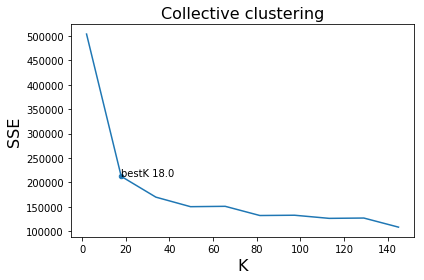

In [8]:
#choose K for global clustering 

%matplotlib inline
x=sorted(K.keys())
y=[K[k]['inertia'] for k in x]
best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=10)

best_k=18 #a mano
pylab.title("Collective clustering",fontsize=16)
pylab.ylabel("SSE",fontsize=16)
pylab.xlabel("K",fontsize=16)
pylab.tight_layout()
# pylab.savefig('%s.png' %(raw_data),dpi=200)

import pandas as pd
df_sse=pd.DataFrame([x,y]).T
df_sse.columns=['x','y']
#df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)

### Exporting results

In [9]:
cluster_centers_=K[best_k]['estimator'].cluster_centers_
labels_=K[best_k]['estimator'].labels_
fw=open(collective_clusters,"w")
fw2=open(collective_labels,"w")
fw.write('collective_cluster;d0;d1;d2;d3;d4;d5;d6\n')
fw2.write('customer_tag;individual_cluster;collective_cluster;d0;d1;d2;d3;d4;d5;d6\n')
#export individual centroids
for i in np.arange(len(cluster_centers_)):
    string="%s;%s\n"%(i,';'.join([str(el) for el in cluster_centers_[i]])) #cluster_id,centroid
    fw.write(string)
fw.flush()

#export original data and labels
for i in np.arange(len(data)):
    uid=data[i][0]
    profile=data[i][1]
    label=labels_[i]
    string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
    fw2.write(string)
fw2.flush()

print('Done')

Done
